# Model Experimentation
**Author:** Robert Smith  
**Date:** 06-18-2020

In this notebook, we'll explore several different classification algorithms to determine which one has the highest accuracy on our data set.

## Preparing the tools

We're going to use standard tools in the Data Scientist's toolbox.

In [1]:
# Import all the tools we need
# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Other functions needed from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

We're also going to be using XGBoost for this project...

In [2]:
# Import xgboost
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost still needs to be installed")

print(xgb.__version__)

1.1.1


## Load Data

We'll load the tidy data set created in the data transformation notebook.

In [3]:
df = pd.read_csv("../data/02_df_tidy.csv")

## Prepare Data For Pipeline

In [4]:
# Split data into X and y
X = df.drop("target", axis = 1)
y = df["target"]

In [5]:
# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 123)

Now we've got our data split into training and test sets, it's time to build a machine learning model.

## Hyperparameter tuning with RandomizedSearchCV

We're going to tune:
* `LogisticRegression()`
* `KNearestNeighbors`
* `GradientBoostingClassifier()`
* `XGBClassifier()`

... using RandomizedSearchCV

Here's how we'll tackle our model evaluation process:
1. Create hyperparameter grids for each model and store them together in a single dictionary known as `param_grid`
2. Create a models dictionary we will use to instantiate each model 
3. Create a data pre-processing pipeline to adequately handle categorical, numeric, and binary variables
4. Create a `fit_and_score` function to loop through and train each model.

In [6]:
# Set random seed for selection of hyperparameters when doing random sampling
np.random.seed(42)

# Create a hyperparameter grid for Logistic Regression
log_reg_grid = {"model__penalty": ["l2", "l1"],
                "model__C": np.logspace(-4, 4, 30), 
                "model__solver" : ["liblinear"]}

# Create a hyperparameter grid for KNearestNeighbors
kn_grid = {"model__n_neighbors" : range(1, 21)}

# Create a hyperparameter grid for GradientBoostingClassifier
gbc_grid = {"model__learning_rate": np.random.uniform(0,.1,20),
            "model__n_estimators" : [50, 100, 150, 200, 500, 1000],
            "model__loss" : ["deviance", "exponential"],
            "model__max_depth": [i for i in range(2,9)]}

# Create a hyperparamter grid for XGBClassifier
xgb_grid = {"model__booster": ["gbtree", "gblinear", "dart"],
            "model__learning_rate": np.random.uniform(0,.1,20),
            "model__tree_depth": [i for i in range(2,9)],
            "model__n_estimator": [50, 100, 150, 200, 500, 1000]}

In [7]:
# Create a dictionary with all of the hyperparameter grids
param_grid = {"LR" : log_reg_grid,
              "KNN": kn_grid,
              "GBC" : gbc_grid, 
              "XGB" : xgb_grid}

# Put models into a dictionary
models = {"LR": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "GBC": GradientBoostingClassifier(), 
          "XGB": xgb.XGBClassifier()}

In [8]:
# Let's split up our features into three different groups that will undergo separate transformations:
cat_vars = ["cp","restecg","thal"]
num_vars = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope","ca"]
bin_vars = ["sex", "fbs", "exang"]


cat_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent")),
                                    ("ohe", OneHotEncoder())])
                                   

num_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent")),
                                    ("scaler", StandardScaler())])

bin_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent"))])

preprocessor = ColumnTransformer(transformers = [('cat', cat_transformer, cat_vars),
                                                  ('num', num_transformer, num_vars),
                                                  ('bin', bin_transformer, bin_vars)],
                                  remainder = "drop")

In [9]:
# Create a function to fit and score models
def fit_and_score(models, param_grid, preprocessor, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different sklearn machine learning models
    param_grid: a dict of hyperparameter grids
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a lists to keep model scores
    train_scores = []
    test_scores = []
    # Loop through models
    for name, model in models.items():
        model_pipeline = Pipeline(steps = [
            ("preprocessing", preprocessor),
            ("model",model)])

        # Fit grid hyperparameter search model
        gs_model = RandomizedSearchCV(model_pipeline, param_grid[name], cv = 10, 
                                      n_iter = 40, random_state = 42, iid = False)
        gs_model.fit(X_train, y_train)
        train_scores.append([name,"Train",gs_model.best_score_])
        test_scores.append([name,"Test",gs_model.score(X_test, y_test)])
        print(f"{name} complete.")
    
    model_scores = pd.DataFrame(train_scores+test_scores,columns = ["Model", "Data", "Accuracy"])
    return model_scores

In [10]:
model_scores = fit_and_score(models, param_grid, preprocessor, X_train, X_test, y_train, y_test)

LR complete.


/Users/RobertSmith/data-science-projects/heart-disease-classification/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


KNN complete.
GBC complete.
[21:34:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

[21:34:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:34:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:34:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:35:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

In [11]:
model_scores

,Model,Data,Accuracy
0,LR,Train,0.854808
1,KNN,Train,0.841667
2,GBC,Train,0.834295
3,XGB,Train,0.850962
4,LR,Test,0.803279
5,KNN,Test,0.754098
6,GBC,Test,0.704918
7,XGB,Test,0.721311


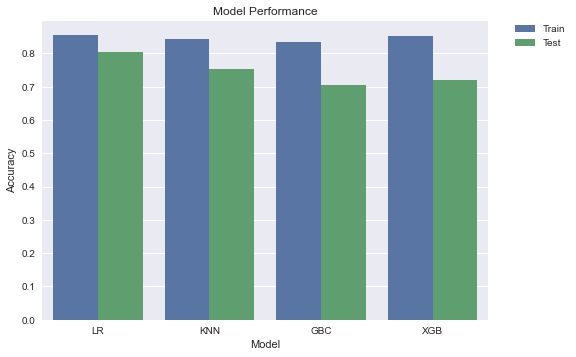

In [12]:
sns.barplot(x = "Model", y = "Accuracy", hue = "Data", data = model_scores)
plt.title("Model Performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Our initial modeling indicates that a logistic regression model fits the best based on our cross-validated training accuracy score. I'm curious how these models would perform on the raw data, instead of the pre-processed data created in the data preparation notebook. 

In [13]:
col_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
             "thalach", "exang", "oldpeak", "slope","ca", "thal", "target"]

raw_df = pd.read_csv("../data/processed.cleveland.data", names = col_names, na_values = "?")

In [14]:
# Split data into X and y
X_raw = raw_df.drop("target", axis = 1)
y_raw = (raw_df["target"] > 0).astype(int)

In [15]:
# Split into train & test
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, 
                                                    test_size = 0.2,
                                                    random_state = 123)

The data processing pipeline only needs to scale the features since they are all numeric. I'll treat them all as continuous features for the sake of simplicity in this pipeline...

In [16]:
# Create a function to fit and score models
def fit_and_score_raw(models, param_grid, X_raw_train, X_raw_test, y_raw_train, y_raw_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different sklearn machine learning models
    param_grid: a dict of hyperparameter grids
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    # Make a lists to keep model scores
    train_scores = []
    test_scores = []
    # Loop through models
    for name, model in models.items():
        model_pipeline = Pipeline(steps = [
            ("imputer", SimpleImputer(strategy = "most_frequent")),
            ("scaler", StandardScaler()),
            ("model",model)])

        # Fit grid hyperparameter search model
        gs_model = RandomizedSearchCV(model_pipeline, param_grid[name], cv = 10, 
                                      n_iter = 40, random_state = 42, iid=False)
        gs_model.fit(X_raw_train, y_raw_train)
        train_scores.append([name,"Train",gs_model.best_score_])
        test_scores.append([name,"Test",gs_model.score(X_raw_test, y_raw_test)])
        print(f"{name} complete.")
    
    model_scores = pd.DataFrame(train_scores+test_scores,columns = ["Model", "Data", "Accuracy"])
    return model_scores

In [17]:
raw_model_scores = fit_and_score_raw(models, param_grid, X_raw_train, X_raw_test, y_raw_train, y_raw_test)

LR complete.


/Users/RobertSmith/data-science-projects/heart-disease-classification/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


KNN complete.
GBC complete.
[21:38:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

[21:38:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:38:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:39:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

In [18]:
raw_model_scores

,Model,Data,Accuracy
0,LR,Train,0.859295
1,KNN,Train,0.855128
2,GBC,Train,0.830128
3,XGB,Train,0.858974
4,LR,Test,0.754098
5,KNN,Test,0.803279
6,GBC,Test,0.704918
7,XGB,Test,0.786885


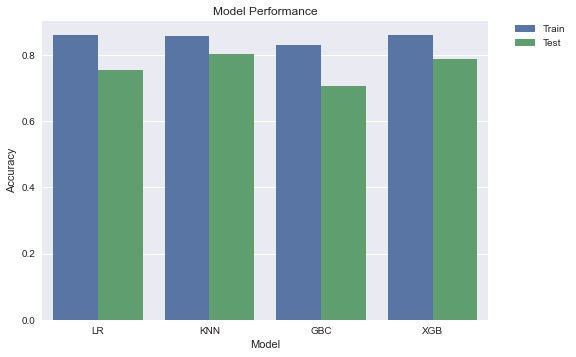

In [19]:
sns.barplot(x = "Model", y = "Accuracy", hue = "Data", data = raw_model_scores)
plt.title("Model Performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

The performance hasn't changed much and actually appears to have some additional overfitting occuring with the logistic regression model. We won't pursue this approach any further.

There is one last thing I am curious about trying - what if a power transformer is used on the input features to make them more gaussian before model fitting (recall the skew in the data exploration phase)?

In [20]:
num_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent")),
                                    ("scaler", PowerTransformer())]) # Here we are using a power-transform instead.

preprocessor_pt = ColumnTransformer(transformers = [('cat', cat_transformer, cat_vars),
                                                  ('num', num_transformer, num_vars),
                                                  ('bin', bin_transformer, bin_vars)],
                                  remainder = "drop")

In [21]:
model_scores_pt = fit_and_score(models, param_grid, preprocessor_pt, X_train, X_test, y_train, y_test)

LR complete.


/Users/RobertSmith/data-science-projects/heart-disease-classification/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


KNN complete.
GBC complete.
[21:43:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  p

[21:43:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:43:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:43:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 


[21:43:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.

[21:43:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:43:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

[21:44:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator, tree_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core. 

In [22]:
model_scores_pt

,Model,Data,Accuracy
0,LR,Train,0.846795
1,KNN,Train,0.838462
2,GBC,Train,0.834295
3,XGB,Train,0.850962
4,LR,Test,0.836066
5,KNN,Test,0.754098
6,GBC,Test,0.704918
7,XGB,Test,0.721311


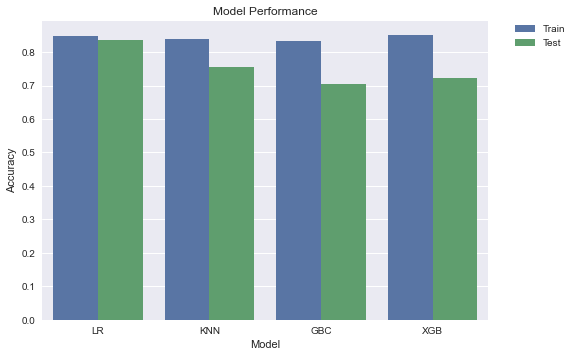

In [23]:
sns.barplot(x = "Model", y = "Accuracy", hue = "Data", data = model_scores_pt)
plt.title("Model Performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Based on all of the modeling, a penalized logistic regression model using the pre-processed data and a power transform for the numeric inputs seems to provide the best results. In the next notebook we'll finalize our penalized logistic regression pipeline and more thoroughly explore the model's performance.